## Usando o rENA no python

O exemplo abaixo mostra como utilizar a biblioteca do R rENA com a liguagem python.
Todas as bibliotecas do python podem ser usadas para mnipular e arrumar os dados para serem plotados.

Todas as funçoes da biblioteca podem ser chamadas usando a interface rENA, um outro detalhe ,e que os pontos (.) devem ser substituidos por underscore (_)
Exemplo:
    A função ena.plot() pode ser chamada usando rENA.ena_plot()
    A função ena.plot.points() pode ser chamada usando rENA.ena_plot_points().
    
### Bibliotecas necessárias:
    Devem ser instaladas as bibliotecas R rENA e data.table usando os comandos abaixo:
    install.packages("rENA")
    install.packages("data.table")
    
    No python devemos instalar a biblioteca rpy2 usando o seguinte comando:
    pip install rpy2
    
    

In [1]:
# -*- coding: UTF-8 -*-

from pandas import read_csv, DataFrame
from plotnine import ggplot, geom_point, geom_label, geom_line, aes, stat_smooth, facet_wrap, coord_fixed
from rpy2.robjects import pandas2ri, Formula
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
pandas2ri.activate()  # makes some conversions automatic

## Importação da biblioteca rENA do R
Suas funções estarão disponíveis na variável "rENA"

In [2]:
rENA = importr('rENA')

## A função robjects possibilita a utilização de funções do R dentro python

In [3]:
#funções do R preparadas para serem chamadas no python
pr = ro.r("print")
colMeans = ro.r("colMeans")
rmax = ro.r("max")

In [4]:
# Leitura dos dados a serem plotados
rsdata = read_csv("/home/jovyan/data/rsdata.csv")

## Identificar colunas para usar no acumulador
Antes de executar a função ena_accumulate_data, precisamos primeiro identificar quais colunas de dados usar em nossas unidades (units), conversas (conversation) e códigos (codes). Há também um parâmetro opcional de metadados (meta), que é para dados específicos da unidade que desejamos realizar no processo de acumulação e nos manter associados às unidades identificadas.

In [5]:
units = rsdata[['Condition','UserName']]
conversation = rsdata[['Condition','GroupName']]
codes = rsdata[['Data','Technical.Constraints','Performance.Parameters','Client.and.Consultant.Requests','Design.Reasoning','Collaboration']]
meta = rsdata[["CONFIDENCE.Change","CONFIDENCE.Pre","CONFIDENCE.Post","C.Change"]]

## Executando a acumulação dos dados
Com os dados identificados e subconjuntos, a acumulação e a geração de conjuntos são bastante simples.

In [6]:
accum = rENA.ena_accumulate_data(units, conversation, codes, meta)

## Gerando o set (confjunto) ENA
A forma mais básica de um ENAset pode ser gerada passando o resultado da chamada da função ena_accumulate_data para ena_make_set.

In [7]:
enaset = rENA.ena_make_set(
  enadata=accum
)

## Plot Units In Each Group

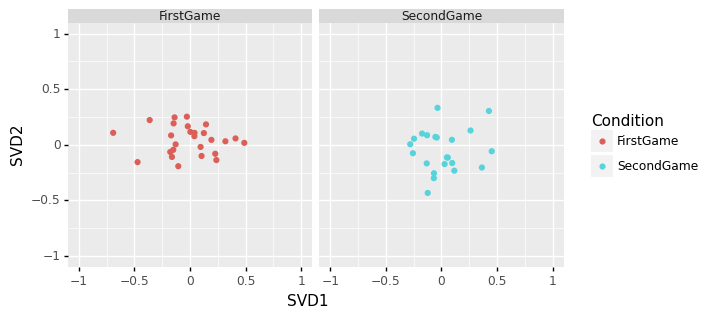

In [8]:
points = enaset.rx2('points')

# df_points1 = points.loc[points['Condition'] == "FirstGame"]
# df_points2 = points.loc[points['Condition'] == "SecondGame"]
# ### Subset rotated points for the first condition
# first_game_points = df_points1.drop(columns=['ENA_UNIT','Condition','UserName', 'CONFIDENCE.Change', 'CONFIDENCE.Pre', 'CONFIDENCE.Post', "C.Change"])
# ### Subset rotated points for the second condition
# second_game_points = df_points2.drop(columns=['ENA_UNIT','Condition','UserName',  'CONFIDENCE.Change', 'CONFIDENCE.Pre', 'CONFIDENCE.Post', "C.Change"])

plot = ggplot(data=points)
plot += geom_point(mapping=aes(x="SVD1", y="SVD2", color="Condition"))
plot += coord_fixed(ratio=1, xlim=(-1, 1), ylim=(-1, 1))
plot += facet_wrap("Condition")
print(plot)

## Plotting Networks

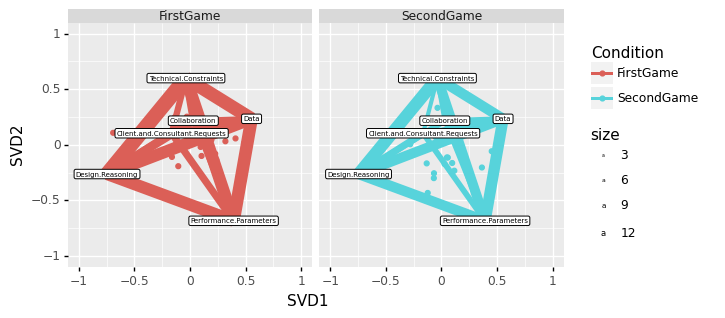

In [9]:
counts = enaset.rx2("connection.counts")
grouped_points = counts.groupby("Condition").mean()
nodes = enaset.rx2("rotation").rx2("nodes")
for _, node1 in nodes.iterrows():
    for _, node2 in nodes.iterrows():
        connection = f"{node1.code} & {node2.code}"
        if connection in grouped_points.columns:
            xs = []
            ys = []
            conditions = []
            sizes = []
            xs.append(node1.SVD1)
            xs.append(node2.SVD1)
            ys.append(node1.SVD2)
            ys.append(node2.SVD2)
            sizes.append(grouped_points[connection].values[0])
            sizes.append(grouped_points[connection].values[0])
            conditions.append(grouped_points.index[0])
            conditions.append(grouped_points.index[0])
            xs.append(node1.SVD1)
            xs.append(node2.SVD1)
            ys.append(node1.SVD2)
            ys.append(node2.SVD2)
            sizes.append(grouped_points[connection].values[1])
            sizes.append(grouped_points[connection].values[1])
            conditions.append(grouped_points.index[1])
            conditions.append(grouped_points.index[1])
            edges = DataFrame({"SVD1": xs, "SVD2": ys, "Condition": conditions, "size": sizes})
            plot += geom_line(data=edges, mapping=aes(x="SVD1/3", y="SVD2/3", size="size", color="Condition"))
            
plot += geom_point(data=nodes, mapping=aes(x="SVD1/3", y="SVD2/3"))
plot += geom_label(data=nodes, mapping=aes(x="SVD1/3", y="SVD2/3", label="code", size=8))
print(plot)

## Subtraction Plot

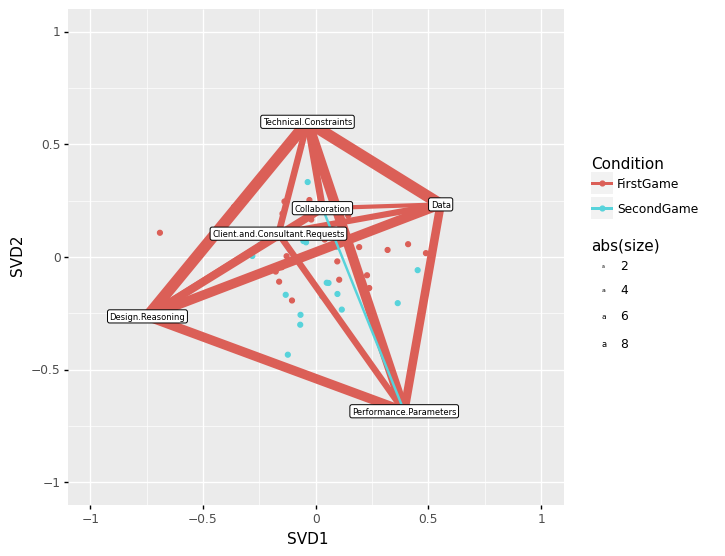

In [10]:
subbed = grouped_points.iloc[1] - grouped_points.iloc[0]
plot = ggplot(data=points)
plot += geom_point(mapping=aes(x="SVD1", y="SVD2", color="Condition"))
plot += coord_fixed(ratio=1, xlim=(-1, 1), ylim=(-1, 1))
for _, node1 in nodes.iterrows():
    for _, node2 in nodes.iterrows():
        connection = f"{node1.code} & {node2.code}"
        if connection in grouped_points.columns:
            xs = []
            ys = []
            conditions = []
            sizes = []
            xs.append(node1.SVD1)
            xs.append(node2.SVD1)
            ys.append(node1.SVD2)
            ys.append(node2.SVD2)
            sizes.append(subbed[connection])
            sizes.append(subbed[connection])
            if subbed[connection] < 0:
                conditions.append(grouped_points.index[0])
                conditions.append(grouped_points.index[0])
            else:
                conditions.append(grouped_points.index[1])
                conditions.append(grouped_points.index[1])
                
            edges = DataFrame({"SVD1": xs, "SVD2": ys, "Condition": conditions, "size": sizes})
            plot += geom_line(data=edges, mapping=aes(x="SVD1/3", y="SVD2/3", size="abs(size)", color="Condition"))
            
plot += geom_point(data=nodes, mapping=aes(x="SVD1/3", y="SVD2/3"))
plot += geom_label(data=nodes, mapping=aes(x="SVD1/3", y="SVD2/3", label="code", size=8))
print(plot)

## Plotting Means

In [11]:
# plot = rENA.ena_plot(set, scale_to = [-1, 0, 1], title ="Groups and Means")
# plot = rENA.ena_plot_points(plot, points = first_game_points, confidence_interval ="box", colors = ("blue"))
# plot = rENA.ena_plot_points(plot, points = second_game_points, confidence_interval ="box", colors = ("red"))
# plot = rENA.ena_plot_group(plot, first_game_points, colors = ("red"), confidence_interval ="box")
# plot = rENA.ena_plot_group(plot, second_game_points, colors =("blue"), confidence_interval ="box")
# pr(plot)

## Plotting a Network

In [12]:
# line_weights = (set.rx2('line.weights'))

# ### Subset lineweights for SecondGame and Calculate the colMeans
# first_game_lineweights = line_weights.loc[points['Condition'] == "FirstGame"]
# second_game_lineweights = line_weights.loc[points['Condition'] == "SecondGame"]

# first_game_lineweights = first_game_lineweights.drop(columns=['ENA_UNIT','Condition','UserName', 'CONFIDENCE.Change', 'CONFIDENCE.Pre', 'CONFIDENCE.Post', "C.Change"])
# ### Subset rotated points for the second condition
# second_game_lineweights = second_game_lineweights.drop(columns=['ENA_UNIT','Condition','UserName',  'CONFIDENCE.Change', 'CONFIDENCE.Pre', 'CONFIDENCE.Post', "C.Change"])

# first_game_mean = colMeans(first_game_lineweights)
# second_game_mean = colMeans(second_game_lineweights)

# subtracted_mean = first_game_mean - second_game_mean

In [13]:
# plot_first = rENA.ena_plot(set, title ="FirstGame")
# plot_first = rENA.ena_plot_network(plot_first, network = first_game_mean)
# pr(plot_first)

In [14]:
# plot_second = rENA.ena_plot(set, title ="SecondGame")
# plot_second = rENA.ena_plot_network(plot_second, network = second_game_mean, colors = ("blue"))
# pr(plot_second)

## Plot subtracted network only

In [15]:
# plot_sub = rENA.ena_plot(set, title ="Subtracted")
# plot_sub = rENA.ena_plot_network(plot_sub, network = subtracted_mean)
# pr(plot_sub)

## Plot Everything Together

In [16]:
# rotation = (set.rx2('rotation'))
# nodes = rotation.rx2('nodes')

# # Scale the nodes to match that of the network, for better viewing
# first_game_points_max = rmax(first_game_points)
# second_game_points_max = rmax(second_game_points)
# if(first_game_points_max> second_game_points_max):
#   point_max = first_game_points_max
# else:
#   point_max = second_game_points_max

# nodes = nodes.drop(columns=['code'])
# max_nodes = rmax(nodes)
# with localconverter(ro.default_converter + pandas2ri.converter):
#   first_game_points = ro.conversion.py2rpy(first_game_points)

# first_game_scaled = first_game_points
# second_game_scaled = second_game_points

# plot = rENA.ena_plot(set, title ="Plot with Units and Network", font_family ="Times")
# plot = rENA.ena_plot_points(plot, points = first_game_scaled, colors = ("red"))
# plot = rENA.ena_plot_points(plot, points = second_game_scaled, colors = ("blue"))
# plot = rENA.ena_plot_group(plot, point = first_game_scaled, colors =("red"), confidence_interval ="box")
# plot = rENA.ena_plot_group(plot, point = second_game_scaled, colors =("blue"), confidence_interval ="box")
# plot = rENA.ena_plot_network(plot, network = subtracted_mean)
# pr(plot)